In [219]:
import pandas as pd
import os
import sqlite3
import openmeteo_requests
import requests_cache
from retry_requests import retry
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Konfigurationsparameter
CONFIG = {
    "DB_PATH": "../nextbike_data_old.db",
    "WEATHER_API_URL": "https://archive-api.open-meteo.com/v1/archive",
    "CSV_BIKES": "city_summaries.csv",
    "CSV_WEATHER": "weather_data.csv",
    "LAT": 49.0094,
    "LON": 8.4044,
    "START_DATE": "2025-09-14",
    "END_DATE": "2025-10-08",
}

In [220]:
def get_nextbike_data(config):
    """Extrahiert die stündlichen Zusammenfassungsdaten aus der Nextbike-SQL-Datenbank"""
    # Falls CSV existiert, direkt laden
    if os.path.exists(config["CSV_BIKES"]):
        print(f"{config['CSV_BIKES']} gefunden. Lade lokale Daten.")
        return pd.read_csv(config["CSV_BIKES"])
    
    # Andernfalls SQL-Datenbank abfragen
    print("Keine CSV gefunden. Starte SQL-Extraktion...")
    try:
        conn = sqlite3.connect(config["DB_PATH"])
        
        # SQL-Abfrage zur Extraktion der stündlichen Zusammenfassungsdaten
        query = """
        SELECT 
            date(timestamp) as date, 
            strftime('%H', timestamp) as hour,
            AVG(available_bikes) as available_bikes, 
            AVG(booked_bikes) as booked_bikes,
            AVG(total_bikes) as total_bikes
        FROM city_summaries
        GROUP BY date, hour
        """
        # Daten aus der SQL-Datenbank in ein DataFrame laden
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        # DataFrame als CSV speichern
        df.to_csv(config["CSV_BIKES"], index=False)
        print("Die Nextbike-Datenbank wurde erfolgreich extrahiert. "
                f"Die Daten wurden in {config['CSV_BIKES']} gespeichert.")
        return df
        
    except sqlite3.Error as e:
        print(f"✗ SQL-Datenbank Fehler: {e}")
        return None


def get_weather_data(config):
    """Ruft Wetterdaten von der Open-Meteo API ab und speichert sie lokal als CSV."""
    # Falls CSV existiert, direkt laden
    if os.path.exists(config["CSV_WEATHER"]):
        print(f"{config['CSV_WEATHER']} gefunden. Lade lokale Daten.")
        return pd.read_csv(config["CSV_WEATHER"])
    
    # Andernfalls API abfragen
    print("Keine CSV gefunden. Rufe Wetterdaten von Open-Meteo ab...")
    try:
        cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)

        # API-Parameter definieren
        params = {
            "latitude": config["LAT"], "longitude": config["LON"],
            "start_date": config["START_DATE"], "end_date": config["END_DATE"],
            "hourly": ["temperature_2m", "rain", "wind_speed_10m"],
            "timezone": "Europe/Berlin",
        }
        responses = openmeteo.weather_api(config["WEATHER_API_URL"], params=params)
        
        # Erste Antwort extrahieren
        res = responses[0]
        hourly = res.Hourly()

        # Daten in ein Dictionary umwandeln
        data = {"timestamp": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()), inclusive="left"
        )}
        # Wettervariablen hinzufügen
        for i, var in enumerate(params["hourly"]):
            data[var] = hourly.Variables(i).ValuesAsNumpy()

        # DataFrame erstellen und als CSV speichern
        df_weather = pd.DataFrame(data=data)
        df_weather.to_csv(config["CSV_WEATHER"], index=False)
        print("Die Wetterdaten wurden erfolgreich extrahiert. "
                f"Die Daten wurden in {config['CSV_WEATHER']} gespeichert.")
        return df_weather
    
    except Exception as e:
        print(f"✗ Wetter-API Fehler: {e}")
        return None

In [221]:
# 1. Daten laden
print ("Starte Setup...")
bikes_df = get_nextbike_data(CONFIG)
weather_df = get_weather_data(CONFIG)

# 2. Vorbereitung zum Mergen (timestamps angleichen)
bikes_df['timestamp'] = pd.to_datetime(bikes_df['date'] + ' ' + bikes_df['hour'].astype(str).str.zfill(2) + ':00:00').dt.tz_localize('UTC')
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])

# 3. Sortieren und Mergen
merged_df = pd.merge_asof(
    bikes_df.sort_values('timestamp'),
    weather_df.sort_values('timestamp'),
    on='timestamp',
    direction='nearest'
)

print("Setup abgeschlossen. 'merged_df' steht für Analysen bereit.")

Starte Setup...
Keine CSV gefunden. Starte SQL-Extraktion...
Die Nextbike-Datenbank wurde erfolgreich extrahiert. Die Daten wurden in city_summaries.csv gespeichert.
Keine CSV gefunden. Rufe Wetterdaten von Open-Meteo ab...
Die Wetterdaten wurden erfolgreich extrahiert. Die Daten wurden in weather_data.csv gespeichert.
Setup abgeschlossen. 'merged_df' steht für Analysen bereit.


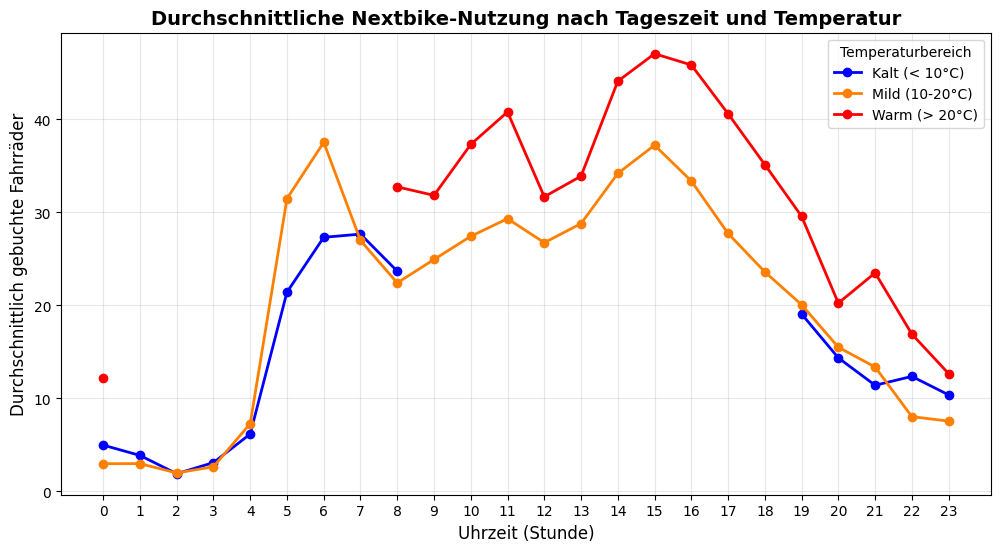

In [222]:
# ANALYSE 1: 24h-Profile nach Temperatur-Clustern
plt.figure(figsize=(12, 6))

# 1. Temperatur-Cluster definieren
def cluster_temp(t):
    if t < 10: return 'Kalt (< 10°C)'
    if t <= 20: return 'Mild (10-20°C)'
    return 'Warm (> 20°C)'

merged_df['temp_cluster'] = merged_df['temperature_2m'].apply(cluster_temp)
merged_df['hour_only'] = merged_df['timestamp'].dt.hour

# 2. Gruppieren nach Stunde und Cluster
hourly_profiles = merged_df.groupby(['hour_only', 'temp_cluster'])['booked_bikes'].mean().unstack()

# 3. Plotten
colors_temp = {'Kalt (< 10°C)': '#0000FF', 'Mild (10-20°C)': '#FF8000', 'Warm (> 20°C)': '#FF0000'}
for cluster in hourly_profiles.columns:
    plt.plot(hourly_profiles.index, hourly_profiles[cluster], 
             label=cluster, marker='o', linewidth=2, color=colors_temp.get(cluster))

plt.title('Durchschnittliche Nextbike-Nutzung nach Tageszeit und Temperatur', fontsize=14, fontweight='bold')
plt.xlabel('Uhrzeit (Stunde)', fontsize=12)
plt.ylabel('Durchschnittlich gebuchte Fahrräder', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Temperaturbereich')
plt.grid(True, alpha=0.3)
plt.show()

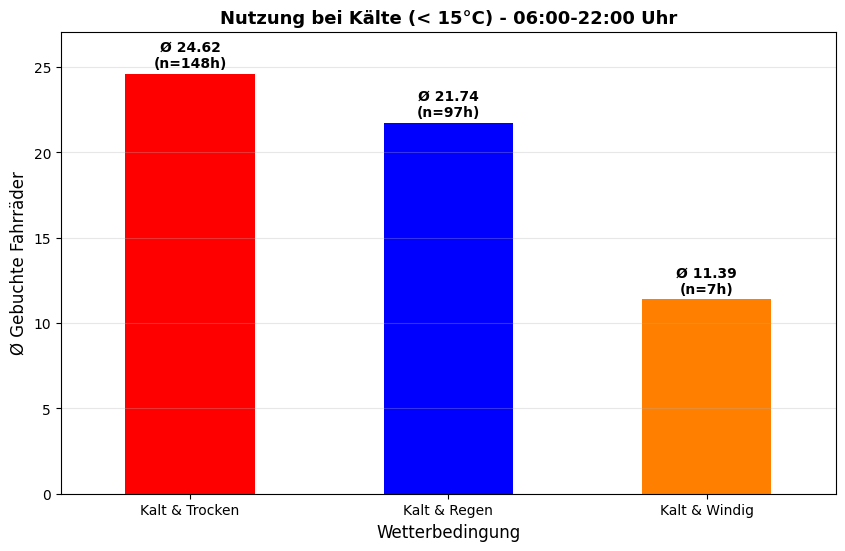

In [223]:
# ANALYSE 2: Einfluss von Wind und Regen bei Kälte
active_cold_hours = merged_df[
    (merged_df['temperature_2m'] < 15) & 
    (merged_df['timestamp'].dt.hour >= 6) & 
    (merged_df['timestamp'].dt.hour <= 22)
].copy()

# Kategorien definieren
def categorize_cold_weather(row):
    if row['rain'] > 0.1: return 'Kalt & Regen'
    if row['wind_speed_10m'] > 20: return 'Kalt & Windig'
    return 'Kalt & Trocken'

active_cold_hours['condition'] = active_cold_hours.apply(categorize_cold_weather, axis=1)

# Statistiken berechnen: Mittelwert und Anzahl der Stunden
stats = active_cold_hours.groupby('condition')['booked_bikes'].agg(['mean', 'count']).sort_values('mean', ascending=False)

# Plotten
plt.figure(figsize=(10, 6))
ax = stats['mean'].plot(kind='bar', color=['#FF0000', '#0000FF', '#FF8000'])

plt.title('Nutzung bei Kälte (< 15°C) - 06:00-22:00 Uhr', fontsize=13, fontweight='bold')
plt.ylabel('Ø Gebuchte Fahrräder', fontsize=12)
plt.xlabel('Wetterbedingung', fontsize=12)
plt.xticks(rotation=0)

# Beschriftung der Säulen mit Ø und Fallzahl n
for i, (idx, row) in enumerate(stats.iterrows()):
    plt.text(i, row['mean'] + 0.2, f"Ø {row['mean']:.2f}\n(n={int(row['count'])}h)", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, stats['mean'].max() * 1.1)
plt.grid(axis='y', alpha=0.3)
plt.show()

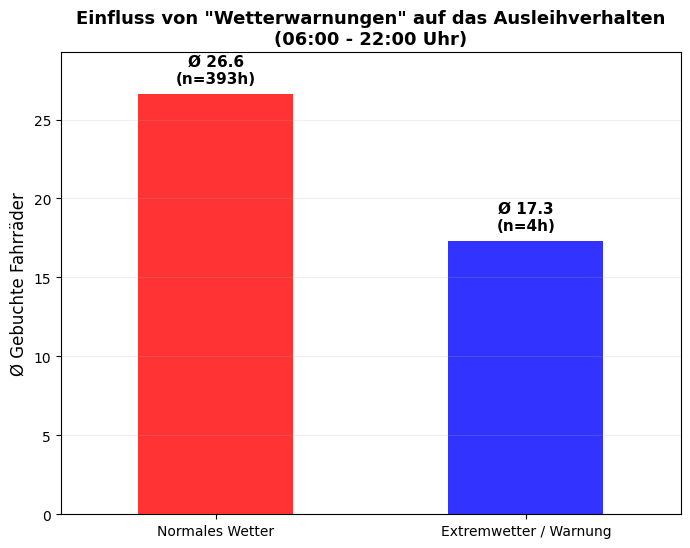

In [224]:
# ANALYSE 3: Einfluss von extremen Wetterereignissen

# 1. Definition der Extremereignisse (Schwellenwerte für "Warnungen")
merged_df['is_extreme'] = (
    (merged_df['rain'] > 3) | 
    (merged_df['wind_speed_10m'] > 30) | 
    ((merged_df['temperature_2m'] < 1) & (merged_df['rain'] > 0))
)

# 2. Vergleich: Durchschnittliche Nutzung bei Extremwetter vs. Normal
core_hours = merged_df[(merged_df['timestamp'].dt.hour >= 6) & (merged_df['timestamp'].dt.hour <= 22)].copy()

# Statistiken berechnen: Mittelwert und Anzahl der Stunden
extreme_stats = core_hours.groupby('is_extreme')['booked_bikes'].agg(['mean', 'count'])
extreme_stats.index = ['Normales Wetter', 'Extremwetter / Warnung']

# 3. Plotten
plt.figure(figsize=(8, 6))
ax = extreme_stats['mean'].plot(kind='bar', color=['#FF0000', '#0000FF'], alpha=0.8)

plt.title('Einfluss von "Wetterwarnungen" auf das Ausleihverhalten\n(06:00 - 22:00 Uhr)', fontsize=13, fontweight='bold')
plt.ylabel('Ø Gebuchte Fahrräder', fontsize=12)
plt.xticks(rotation=0)

# Beschriftung der Säulen mit Ø und Fallzahl n
for i, (idx, row) in enumerate(extreme_stats.iterrows()):
    plt.text(i, row['mean'] + 0.5, f"Ø {row['mean']:.1f}\n(n={int(row['count'])}h)", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim(0, extreme_stats['mean'].max() * 1.1)
plt.grid(axis='y', alpha=0.2)
plt.show()

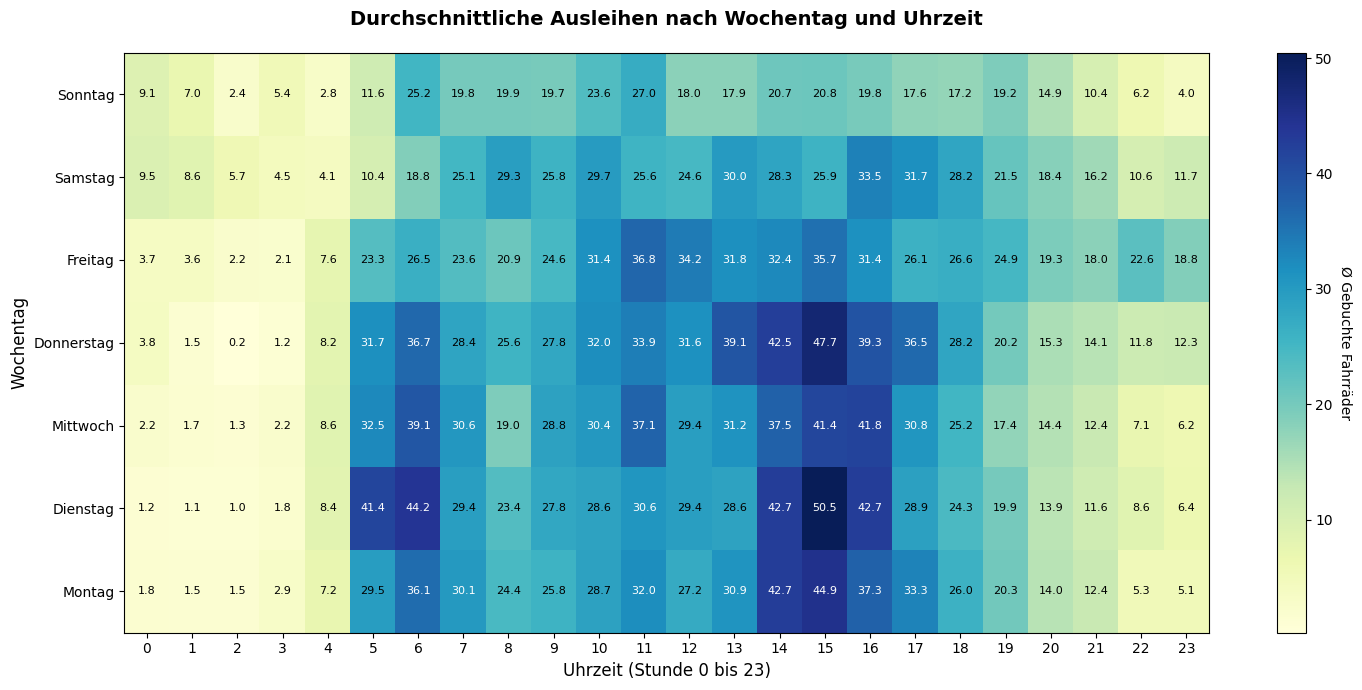

In [225]:
# ANALYSE 4: Heatmap (X=Uhrzeit, Y=Wochentag)

# 1. Daten vorbereiten
heatmap_data = merged_df.copy()
heatmap_data['weekday_num'] = heatmap_data['timestamp'].dt.weekday # 0=Montag, 6=Sonntag
heatmap_data['hour'] = heatmap_data['timestamp'].dt.hour

# Pivot-Tabelle: Index = Wochentage (Y-Achse), Spalten = Stunden (X-Achse)
pivot_df = heatmap_data.groupby(['weekday_num', 'hour'])['booked_bikes'].mean().unstack()
pivot_df = pivot_df.fillna(0)

# 2. Plotten
fig, ax = plt.subplots(figsize=(15, 7))
im = ax.imshow(pivot_df, cmap='YlGnBu', aspect='auto', origin='lower')

# Achsenbeschriftungen
days = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
ax.set_yticks(np.arange(len(days)))
ax.set_yticklabels(days)
ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1))

# Labels
plt.title('Durchschnittliche Ausleihen nach Wochentag und Uhrzeit', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Uhrzeit (Stunde 0 bis 23)', fontsize=12)
plt.ylabel('Wochentag', fontsize=12)

# Farbbalken (Colorbar)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Ø Gebuchte Fahrräder', rotation=-90, va="bottom")

# Werte in die Zellen schreiben
for y in range(len(days)):
    for x in range(24):
        val = pivot_df.iloc[y, x]
        text_color = "white" if val > pivot_df.values.max()/1.7 else "black"
        ax.text(x, y, f"{val:.1f}", ha="center", va="center", color=text_color, fontsize=8)

plt.tight_layout()
plt.show()

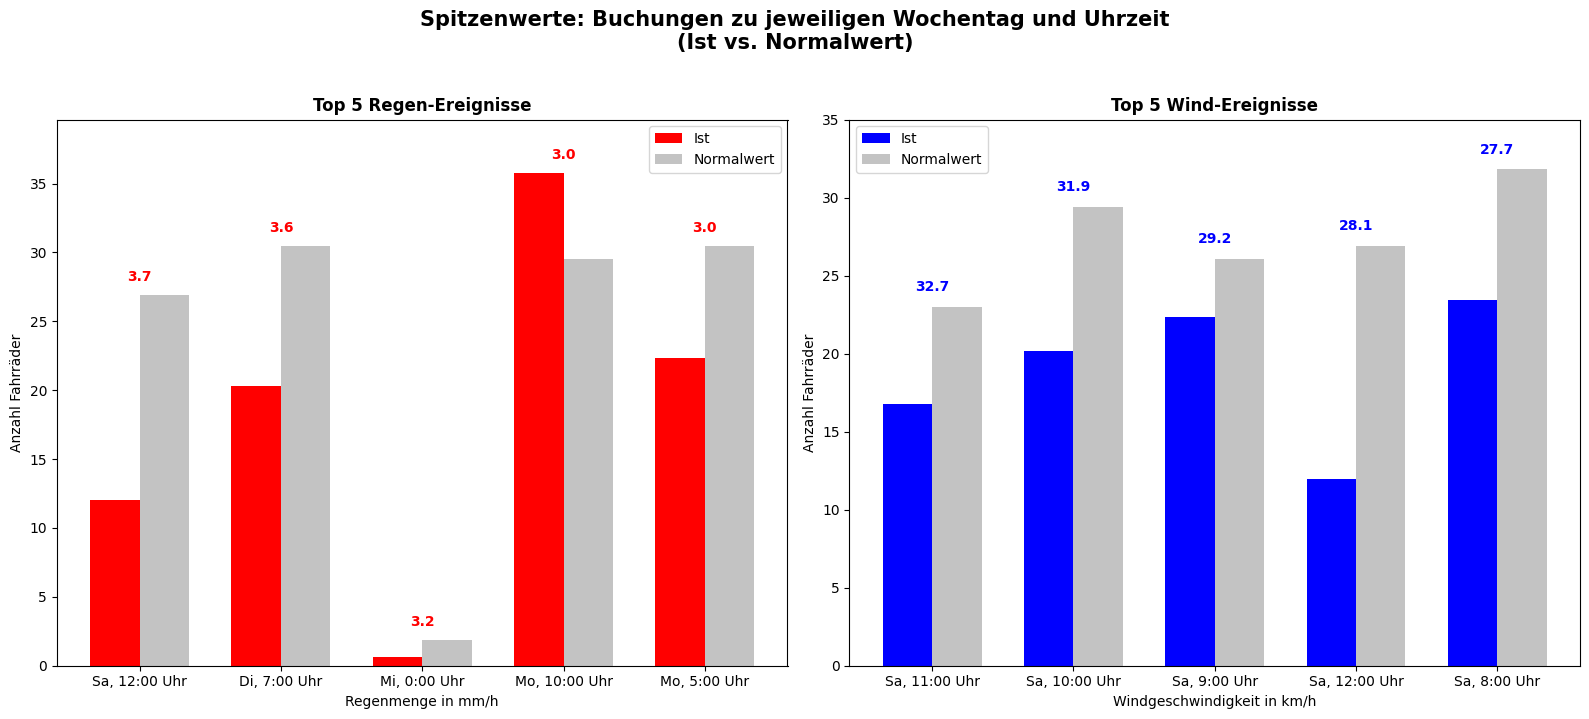

In [226]:
# ANALYSE 5 & 6: Top-Ereignisse vs. Normalzustand

# 1. Temporäre Kopie erstellen, um den Haupt-DF nicht zu verändern
df_temp = merged_df.copy()

# Hilfsspalten für den Vergleich erstellen
df_temp['tmp_weekday'] = df_temp['timestamp'].dt.weekday
df_temp['tmp_hour'] = df_temp['timestamp'].dt.hour

# 2. Referenzwerte berechnen: Median pro Wochentag und Stunde
reference_values = df_temp.groupby(['tmp_weekday', 'tmp_hour'])['booked_bikes'].median().reset_index()
reference_values.columns = ['tmp_weekday', 'tmp_hour', 'typical_booked']

# 3. Referenzwerte an die temporären Daten anfügen
df_with_ref = pd.merge(df_temp, reference_values, on=['tmp_weekday', 'tmp_hour'])

# 4. Top 5 Ereignisse finden
top_rain = df_with_ref.sort_values(by='rain', ascending=False).head(5).copy()
top_wind = df_with_ref.sort_values(by='wind_speed_10m', ascending=False).head(5).copy()

# Hilfsfunktion für die Beschriftung der X-Achse
def format_label(row):
    days = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']
    return f"{days[int(row['tmp_weekday'])]}, {int(row['tmp_hour'])}:00 Uhr"

top_rain['label'] = top_rain.apply(format_label, axis=1)
top_wind['label'] = top_wind.apply(format_label, axis=1)

# 5. Plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
width = 0.35
x = np.arange(5)

# Plot A: Top 5 Regen-Stunden
ax1.bar(x - width/2, top_rain['booked_bikes'], width, label='Ist', color='#FF0000')
ax1.bar(x + width/2, top_rain['typical_booked'], width, label='Normalwert', color='#888888', alpha=0.5)

ax1.set_title('Top 5 Regen-Ereignisse', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(top_rain['label'])
ax1.set_ylabel('Anzahl Fahrräder')
ax1.set_xlabel('Regenmenge in mm/h')
ax1.legend()
ax1.set_ylim(0, top_rain['typical_booked'].max() * 1.3)

for i, val in enumerate(top_rain['rain']):
    ax1.text(i, max(top_rain['booked_bikes'].iloc[i], top_rain['typical_booked'].iloc[i]) + 1, 
             f"{val:.1f}", ha='center', fontsize=10, color='#FF0000', fontweight='bold')

# Plot B: Top 5 Wind-Stunden
ax2.bar(x - width/2, top_wind['booked_bikes'], width, label='Ist', color='#0000FF')
ax2.bar(x + width/2, top_wind['typical_booked'], width, label='Normalwert', color='#888888', alpha=0.5)

ax2.set_title('Top 5 Wind-Ereignisse', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(top_wind['label'])
ax2.set_ylabel('Anzahl Fahrräder')
ax2.set_xlabel('Windgeschwindigkeit in km/h')
ax2.legend()
ax2.set_ylim(0, top_wind['typical_booked'].max() * 1.1)

for i, val in enumerate(top_wind['wind_speed_10m']):
    ax2.text(i, max(top_wind['booked_bikes'].iloc[i], top_wind['typical_booked'].iloc[i]) + 1, 
             f"{val:.1f}", ha='center', fontsize=10, color='#0000FF', fontweight='bold')

plt.suptitle('Spitzenwerte: Buchungen zu jeweiligen Wochentag und Uhrzeit\n(Ist vs. Normalwert)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [227]:
# STATISTISCHE GESAMTÜBERSICHT

print("="*80)
print("STATISTISCHES PROFIL: NEXTBIKE-NUTZUNG VS. METEOROLOGISCHE DATEN")
print("="*80)

# 1. Grundlegende Statistik
total_hours = len(merged_df)
avg_rentals = merged_df['booked_bikes'].mean()
max_rentals = merged_df['booked_bikes'].max()
avg_temp = merged_df['temperature_2m'].mean()
avg_wind = merged_df['wind_speed_10m'].mean()

# 2. Korrelationen und p-Werte berechnen (Signifikanzprüfung)
df_clean = merged_df.dropna(subset=['booked_bikes', 'temperature_2m', 'rain', 'wind_speed_10m'])

r_temp, p_temp = pearsonr(df_clean['temperature_2m'], df_clean['booked_bikes'])
r_rain, p_rain = pearsonr(df_clean['rain'], df_clean['booked_bikes'])
r_wind, p_wind = pearsonr(df_clean['wind_speed_10m'], df_clean['booked_bikes'])

# 3. Binäre Vergleiche (Durchschnittswerte bei verschiedenen Bedingungen)
dry_rentals = merged_df[merged_df['rain'] == 0]['booked_bikes'].mean()
rainy_rentals = merged_df[merged_df['rain'] > 0]['booked_bikes'].mean()

windy_rentals = merged_df[merged_df['wind_speed_10m'] > avg_wind]['booked_bikes'].mean()
calm_rentals = merged_df[merged_df['wind_speed_10m'] <= avg_wind]['booked_bikes'].mean()

warm_rentals = merged_df[merged_df['temperature_2m'] > avg_temp]['booked_bikes'].mean()
cold_rentals = merged_df[merged_df['temperature_2m'] <= avg_temp]['booked_bikes'].mean()

# Ausgabe
print(f"\nDATENBASIS:")
print(f"   - Untersuchungszeitraum: {merged_df['timestamp'].min().strftime('%d.%m.%Y')} bis {merged_df['timestamp'].max().strftime('%d.%m.%Y')}")
print(f"   - Analysierte Stunden:   {total_hours}h")
print(f"   - Ø Ausleihen pro Std:   {avg_rentals:.2f} Räder (Maximum: {max_rentals:.0f})")

print(f"\nDURCHSCHNITTSWERTE IM VERGLEICH:")
print(f"   - Temperatur:   > {avg_temp:.1f}°C - {warm_rentals:>6.2f} Räder | <= {avg_temp:.1f}°C - {cold_rentals:>6.2f} Räder")
print(f"   - Niederschlag:  0.0 mm/h - {dry_rentals:>6.2f} Räder |  > 0.0 mm/h - {rainy_rentals:>6.2f} Räder")
print(f"   - Windstärke:   > {avg_wind:.1f} km/h - {windy_rentals:>6.2f} Räder | <= {avg_wind:.1f} km/h - {calm_rentals:>6.2f} Räder")

print(f"\nALLGEMEINE KORRELATIONEN: r = Korrelationskoeffizient, p = Signifikanzwert")
print(f"   - Temperatur:   r = {r_temp:>6.3f} | p = {p_temp:>8.2e} " + ("*" if p_temp < 0.05 else ""))
print(f"   - Niederschlag: r = {r_rain:>6.3f} | p = {p_rain:>8.2e} " + ("*" if p_rain < 0.05 else ""))
print(f"   - Windstärke:   r = {r_wind:>6.3f} | p = {p_wind:>8.2e} " + ("*" if p_wind < 0.05 else ""))
print("   * markiert statistisch signifikante Ergebnisse (Zusammenhang) mit p < 0.05\n")
print("="*80)

STATISTISCHES PROFIL: NEXTBIKE-NUTZUNG VS. METEOROLOGISCHE DATEN

DATENBASIS:
   - Untersuchungszeitraum: 14.09.2025 bis 08.10.2025
   - Analysierte Stunden:   565h
   - Ø Ausleihen pro Std:   20.94 Räder (Maximum: 62)

DURCHSCHNITTSWERTE IM VERGLEICH:
   - Temperatur:   > 13.4°C -  27.52 Räder | <= 13.4°C -  16.59 Räder
   - Niederschlag:  0.0 mm/h -  21.32 Räder |  > 0.0 mm/h -  19.96 Räder
   - Windstärke:   > 10.5 km/h -  22.06 Räder | <= 10.5 km/h -  20.03 Räder

ALLGEMEINE KORRELATIONEN: r = Korrelationskoeffizient, p = Signifikanzwert
   - Temperatur:   r =  0.460 | p = 5.65e-31 *
   - Niederschlag: r = -0.068 | p = 1.04e-01 
   - Windstärke:   r =  0.005 | p = 9.07e-01 
   * markiert statistisch signifikante Ergebnisse (Zusammenhang) mit p < 0.05

